In [22]:
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
os.getcwd()

'c:\\Users\\sharo\\OneDrive\\Desktop\\BDCC_Assignment'

In [24]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql import functions
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

from pyspark.ml  import Pipeline     
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit, count
import pyspark.sql.functions as f

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

#create session in order to be capable of accessing all Spark API
spark = SparkSession \
    .builder \
    .appName("Purchase") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [26]:
csv_files = glob("./*.csv")
csv_files

['.\\1987.csv',
 '.\\1988.csv',
 '.\\1989.csv',
 '.\\1990.csv',
 '.\\1991.csv',
 '.\\1992.csv',
 '.\\1993.csv',
 '.\\1994.csv',
 '.\\1995.csv',
 '.\\1996.csv',
 '.\\1997.csv',
 '.\\1998.csv',
 '.\\1999.csv',
 '.\\2000.csv',
 '.\\2001.csv',
 '.\\2002.csv',
 '.\\2003.csv',
 '.\\2004.csv',
 '.\\2005.csv',
 '.\\2006.csv',
 '.\\2007.csv',
 '.\\2008.csv',
 '.\\airports.csv',
 '.\\carriers.csv',
 '.\\plane-data.csv',
 '.\\variable-descriptions.csv']

In [27]:
os.getcwd()

'c:\\Users\\sharo\\OneDrive\\Desktop\\BDCC_Assignment'

In [32]:
flight_csv = sorted([i for i in csv_files if len(i.split("\\")[1].rsplit(".",1)[0])==4])
flight_csv

['.\\1987.csv',
 '.\\1988.csv',
 '.\\1989.csv',
 '.\\1990.csv',
 '.\\1991.csv',
 '.\\1992.csv',
 '.\\1993.csv',
 '.\\1994.csv',
 '.\\1995.csv',
 '.\\1996.csv',
 '.\\1997.csv',
 '.\\1998.csv',
 '.\\1999.csv',
 '.\\2000.csv',
 '.\\2001.csv',
 '.\\2002.csv',
 '.\\2003.csv',
 '.\\2004.csv',
 '.\\2005.csv',
 '.\\2006.csv',
 '.\\2007.csv',
 '.\\2008.csv']

In [33]:
c=0
for file in flight_csv:
    if c==0:
        df = spark.read.csv(file, header = "true")
    else:
        df_temp = spark.read.csv(file, header = "true")
        df = df.unionByName(df_temp)
        print((file, df.count(), len(df.columns)))
    c+=1

('.\\1988.csv', 6513922, 29)
('.\\1989.csv', 11555122, 29)
('.\\1990.csv', 16826015, 29)
('.\\1991.csv', 21902940, 29)
('.\\1992.csv', 26995097, 29)
('.\\1993.csv', 32065598, 29)
('.\\1994.csv', 37245646, 29)
('.\\1995.csv', 42573081, 29)
('.\\1996.csv', 47925064, 29)
('.\\1997.csv', 53336907, 29)
('.\\1998.csv', 58721628, 29)
('.\\1999.csv', 64249512, 29)
('.\\2000.csv', 69932559, 29)
('.\\2001.csv', 75900339, 29)
('.\\2002.csv', 81171698, 29)
('.\\2003.csv', 87660238, 29)
('.\\2004.csv', 94789508, 29)
('.\\2005.csv', 101930104, 29)
('.\\2006.csv', 109072026, 29)
('.\\2007.csv', 116525241, 29)
('.\\2008.csv', 118914458, 29)


In [34]:
print((df.count(), len(df.columns)))

(118914458, 29)


In [35]:
df_journies = df.groupBy('Origin', 'Dest').count().toPandas()

In [36]:
df_journies_sorted = df_journies.sort_values(by=['count'], ascending=False)[:12]
df_journies_sorted.head(10)

,Origin,Dest,count
6310,SFO,LAX,329370
4235,LAX,SFO,328105
7017,LAX,LAS,284494
5594,LAS,LAX,278653
5633,PHX,LAX,273286
2847,LAX,PHX,272681
2090,ORD,MSP,243470
7683,MSP,ORD,242933
2150,PHX,LAS,233977
2081,LAS,PHX,232467


In [37]:
airport_names=[]
for i in range(len(df_journies_sorted)):
    origin = df_journies_sorted.iloc[i]['Origin']
    destination = df_journies_sorted.iloc[i]['Dest']
    journey = origin + '-' + destination
    airport_names.append(journey)
df_journies_sorted['trips'] = airport_names

C:\Users\sharo\AppData\Local\Temp\ipykernel_3404\1729694246.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='trips', y='count', data=df_journies_sorted, palette = "mako")


Text(0.5, 1.0, 'Total number of Trips between high traffic Airports')

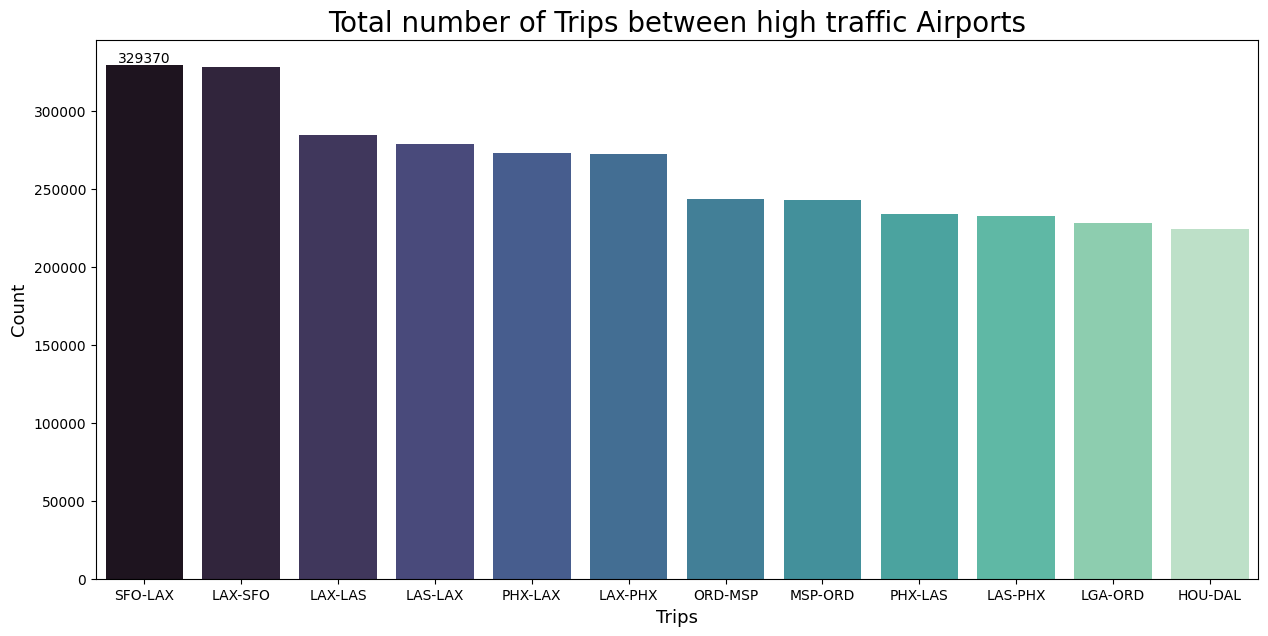

In [38]:
plt.figure(figsize=(15,7))
ax = sns.barplot(x='trips', y='count', data=df_journies_sorted, palette = "mako")
ax.bar_label(ax.containers[0])
plt.xlabel('Trips',size=13)
plt.ylabel('Count',size=13)
plt.title('Total number of Trips between high traffic Airports',size=20)

In [39]:
drop_columns=['Unnamed: 0','CRSDepTime','CRSArrTime','ActualElapsedTime','CRSElapsedTime',
                'AirTime','Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut','CancellationCode','Diverted',
                'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df = df.drop(*drop_columns)
len(df.columns)

12

In [40]:
df_flight = df.groupBy('UniqueCarrier', 'Cancelled').count().toPandas()

Text(0.5, 1.0, 'Airlines-Flight Cancellation Proportions')

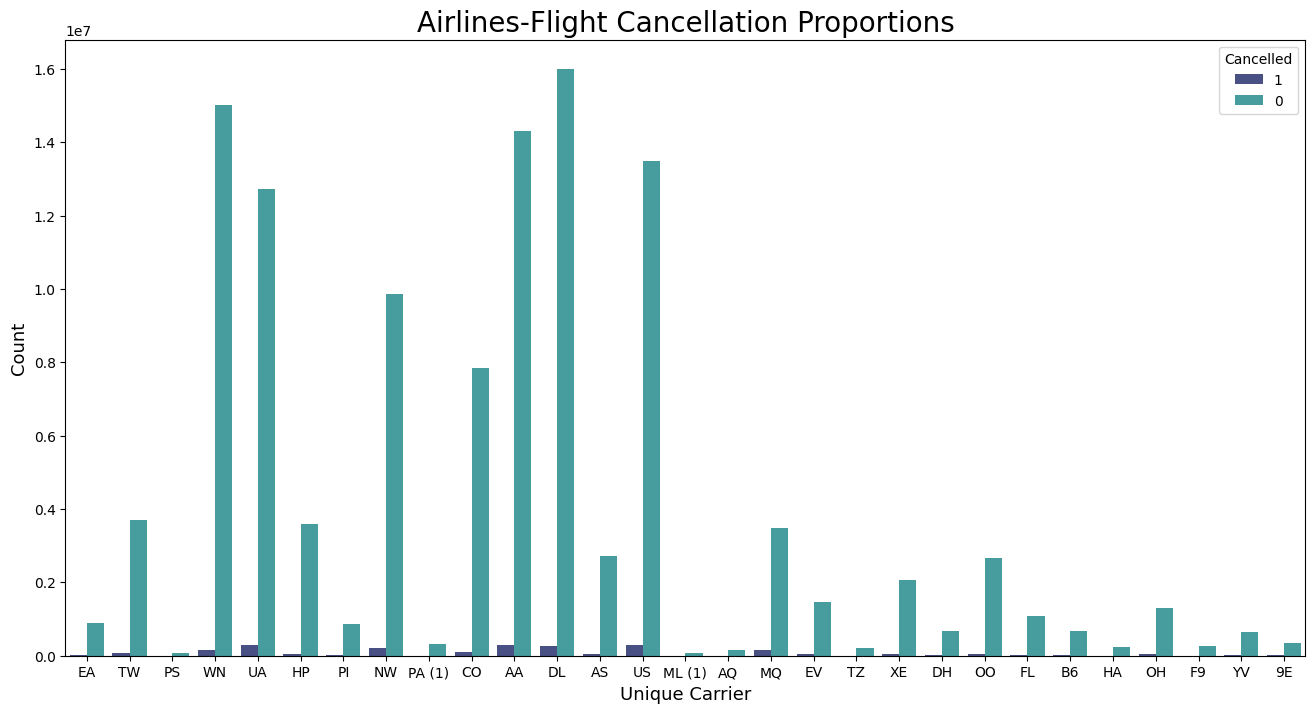

In [41]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x='UniqueCarrier', y='count', hue='Cancelled', data=df_flight, palette = "mako")
plt.xlabel('Unique Carrier',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Airlines-Flight Cancellation Proportions',size=20)

In [42]:
df_year = df.groupBy('Year', 'Cancelled').count().toPandas()

Text(0.5, 1.0, 'Yearly-Flight Cancellation Proportions')

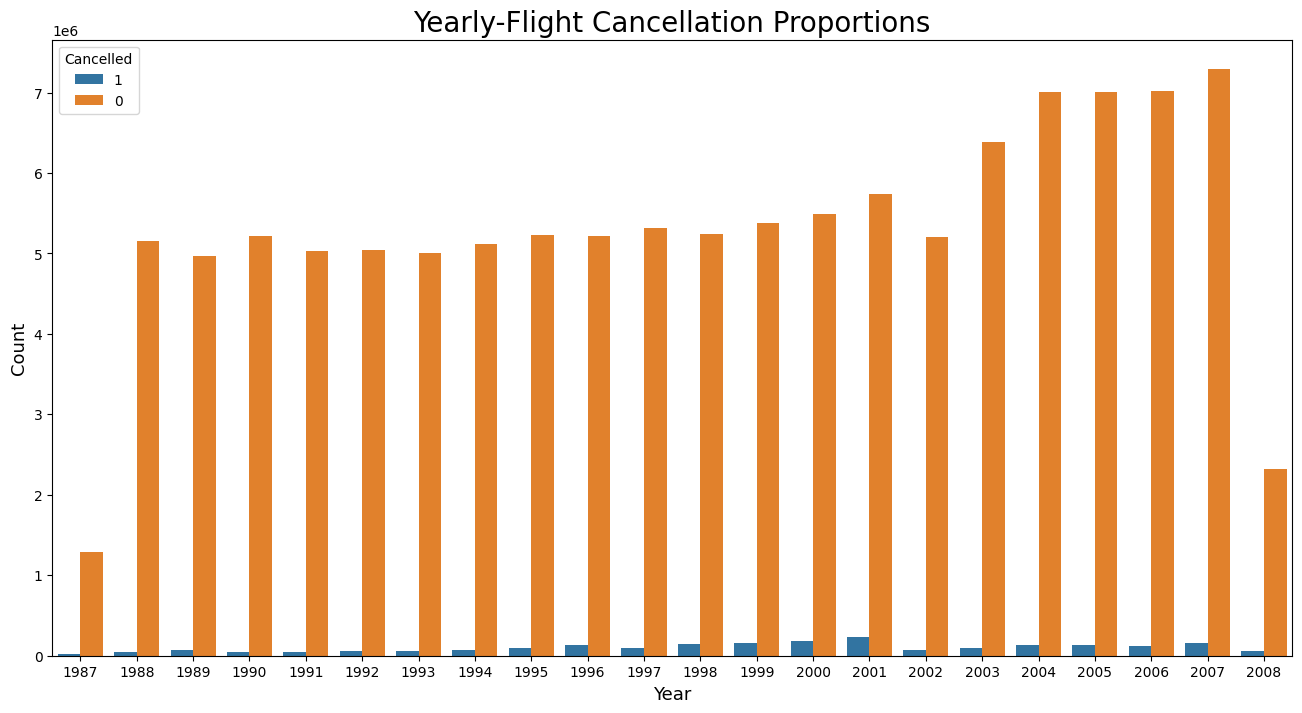

In [43]:
plt.figure(figsize=(16,8))
ax = sns.barplot(x='Year', y='count', hue='Cancelled', data=df_year)
plt.xlabel('Year',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Yearly-Flight Cancellation Proportions',size=20)

In [44]:
# Cancelled flights percentage in data
cancelled = df.filter(df.Cancelled==1)
cancelled = cancelled.drop('Cancelled')
cancelled.show()

+----+-----+----------+---------+-------+-------+-------------+---------+-------+--------+--------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|ArrTime|UniqueCarrier|FlightNum|TailNum|ArrDelay|DepDelay|
+----+-----+----------+---------+-------+-------+-------------+---------+-------+--------+--------+
|1987|   10|        12|        1|     NA|     NA|           PS|     1453|     NA|      NA|      NA|
|1987|   10|        12|        1|     NA|     NA|           PS|     1454|     NA|      NA|      NA|
|1987|   10|         6|        2|     NA|     NA|           PS|     1457|     NA|      NA|      NA|
|1987|   10|        29|        4|     NA|     NA|           PS|     1459|     NA|      NA|      NA|
|1987|   10|        22|        4|     NA|     NA|           PS|     1465|     NA|      NA|      NA|
|1987|   10|         5|        1|     NA|     NA|           PS|     1480|     NA|      NA|      NA|
|1987|   10|        28|        3|     NA|     NA|           PS|     1502|     NA|      NA|      NA|


In [45]:
cancelled_UniqueCarrier = cancelled.groupBy('UniqueCarrier').count().select('UniqueCarrier', f.col('Count')).toPandas()
cancelled_UniqueCarrier.set_index('UniqueCarrier', inplace=True)

<Axes: title={'center': 'Which airline cancelled flights highest number of times?'}, ylabel='Count'>

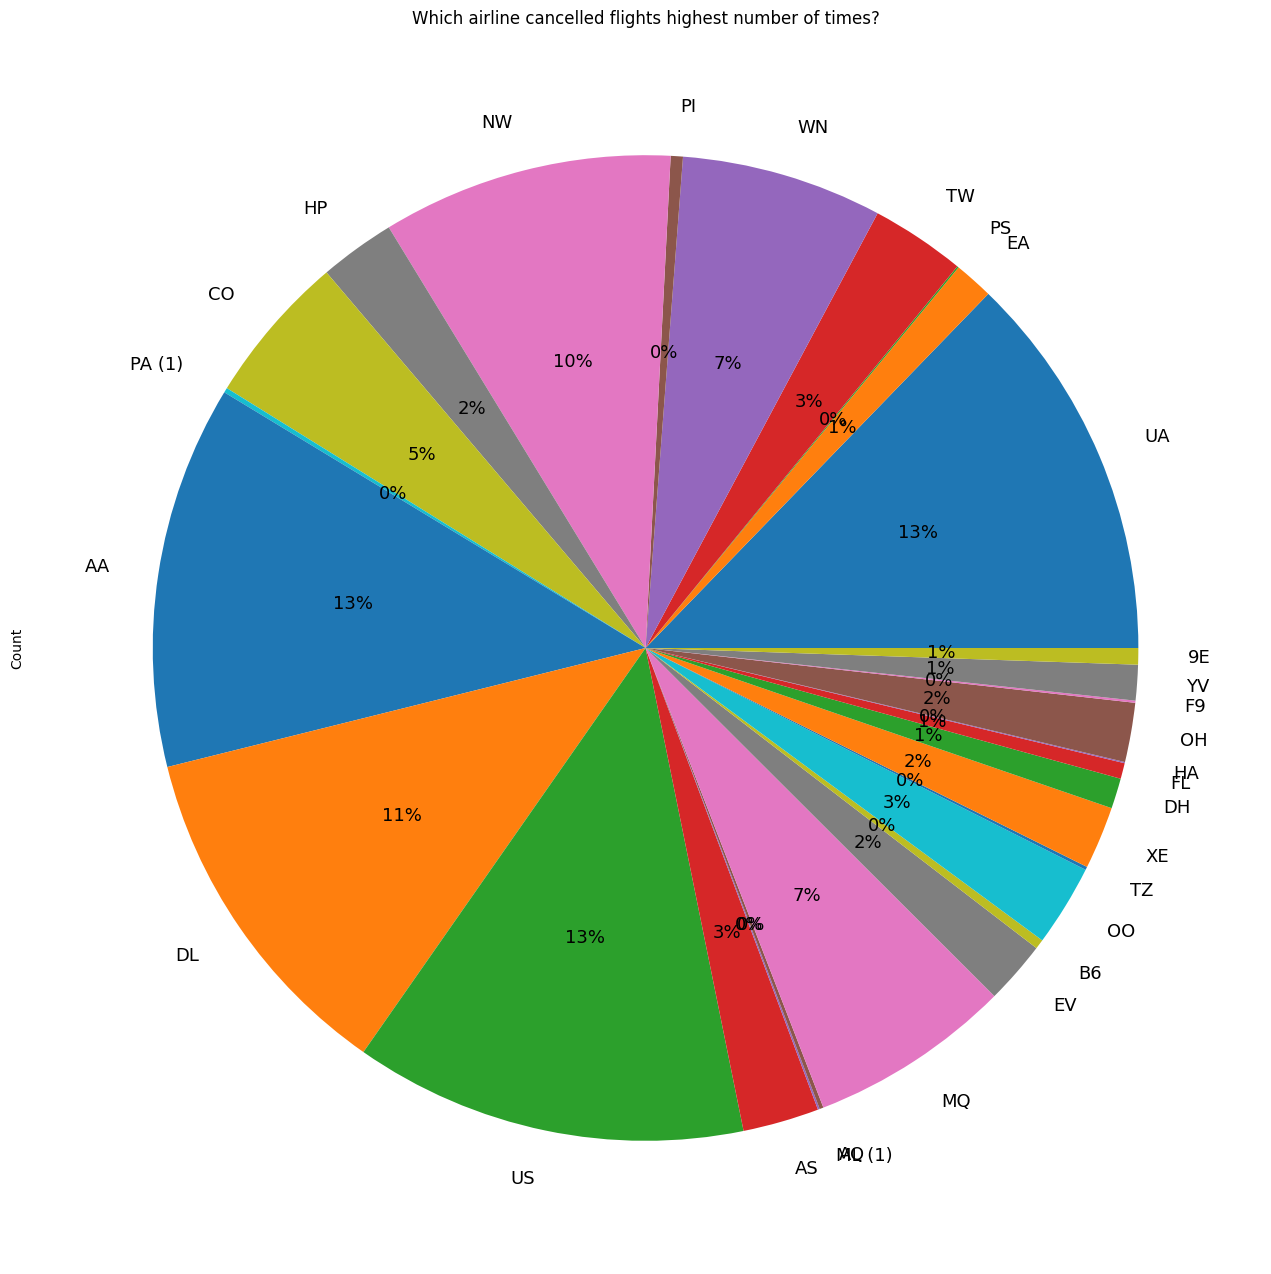

In [46]:
cancelled_UniqueCarrier.plot(kind='pie', y='Count', autopct='%1.0f%%', fontsize=13, legend=False,
                            title='Which airline cancelled flights highest number of times?',
                            figsize=(16,16))

In [47]:
cancelled_year = cancelled.groupBy('Year').count().select('Year', f.col('Count')).toPandas()
cancelled_year.set_index('Year', inplace=True)

In [48]:
cancelled_year_counts = cancelled_year['Count']
year_text = ['{:0.1f}%'.format(v) for v in (cancelled_year_counts/cancelled.count()*100)]

C:\Users\sharo\AppData\Local\Temp\ipykernel_3404\1757554296.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cancelled_year.index,y=cancelled_year_counts, palette = "mako");


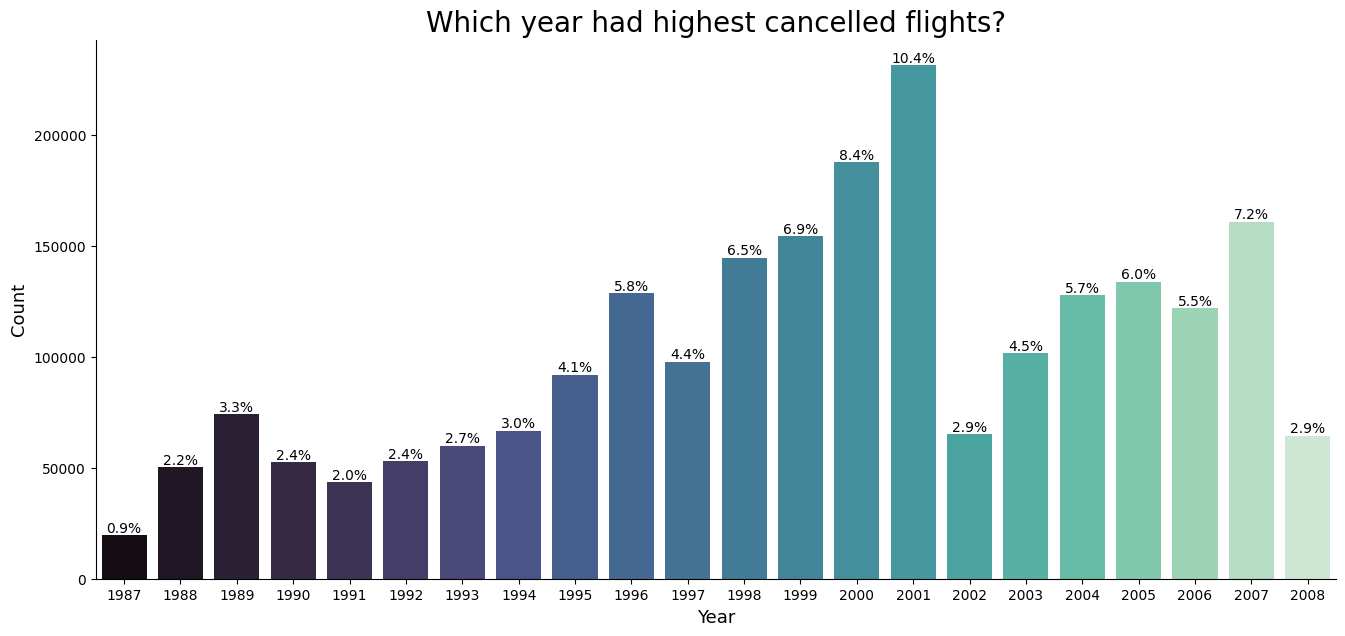

In [49]:
base_color = '#539ecd'
alt=sns.color_palette()[1]
plt.figure(figsize=(16,7))
colors = [base_color if (x < cancelled_year_counts.max()) else alt for x in cancelled_year_counts]
sns.barplot(x=cancelled_year.index,y=cancelled_year_counts, palette = "mako");     
plt.xlabel('Year',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Which year had highest cancelled flights?',size=20) 

for i in range (cancelled_year_counts.shape[0]):
    plt.text(i,                           
             cancelled_year_counts.values[i],       
             year_text[i],                 
             ha='center',                  
             va='bottom')
sns.despine()

In [50]:
df = df.filter(df.Cancelled==0)
flight = df.drop('Cancelled')

In [51]:
flight.na.drop()

DataFrame[Year: string, Month: string, DayofMonth: string, DayOfWeek: string, DepTime: string, ArrTime: string, UniqueCarrier: string, FlightNum: string, TailNum: string, ArrDelay: string, DepDelay: string]

In [52]:
flight.count()

116684126

In [53]:
year = flight.groupBy('Year').count().select('Year', f.col('Count')).toPandas()
year.set_index('Year', inplace=True)

In [54]:
Year_counts = year['Count']
year_text = ['{:0.1f}%'.format(v) for v in (Year_counts/flight.count()*100)]

In [55]:
Year_counts

Year
1987    1292141
1988    5151933
1989    4967035
1990    5218435
1991    5033420
1992    5039321
1993    5010656
1994    5113308
1995    5235530
1996    5223447
1997    5314080
1998    5240212
1999    5373573
2000    5495557
2001    5736582
2002    5206216
2003    6387071
2004    7001513
2005    7006866
2006    7019988
2007    7292467
2008    2324775
Name: Count, dtype: int64

C:\Users\sharo\AppData\Local\Temp\ipykernel_3404\1812380902.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year.index,y=Year_counts, palette = "mako");


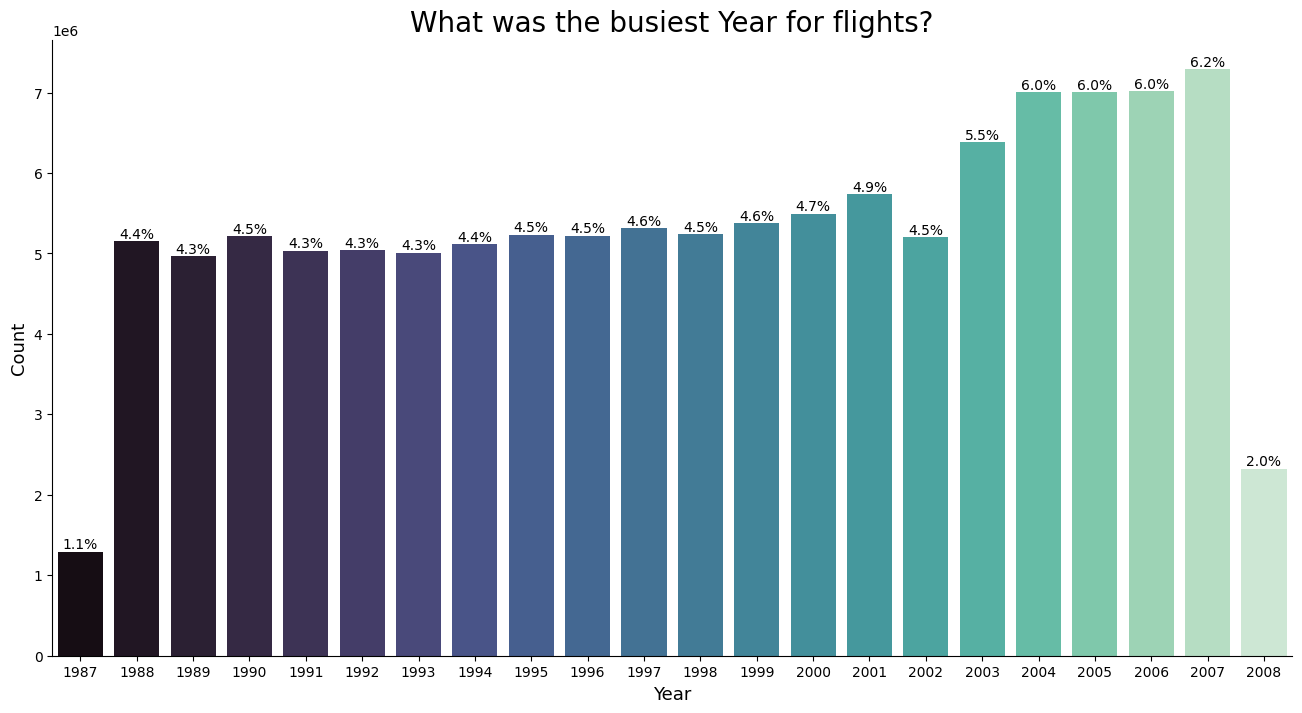

In [56]:
base_color = '#539ecd'
alt=sns.color_palette()[1]
plt.figure(figsize=(16,8))
colors = [base_color if (x < Year_counts.max()) else alt for x in Year_counts]
sns.barplot(x=year.index,y=Year_counts, palette = "mako");     
plt.xlabel('Year',size=13) 
plt.ylabel('Count',size=13)   
plt.title('What was the busiest Year for flights?',size=20) 

for i in range (Year_counts.shape[0]):
    plt.text(i,                           
             Year_counts.values[i],       
             year_text[i],                 
             ha='center',                  
             va='bottom')
sns.despine()     

In [57]:
month = flight.groupBy('Month').count().select('Month', f.col('Count')).toPandas()
month.set_index('Month', inplace=True)

In [58]:
Month_counts = month['Count']
Month_text = ['{:0.1f}%'.format(v) for v in (Month_counts/flight.count()*100)]

C:\Users\sharo\AppData\Local\Temp\ipykernel_3404\3180652878.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month.index,y=Month_counts , palette = "mako");


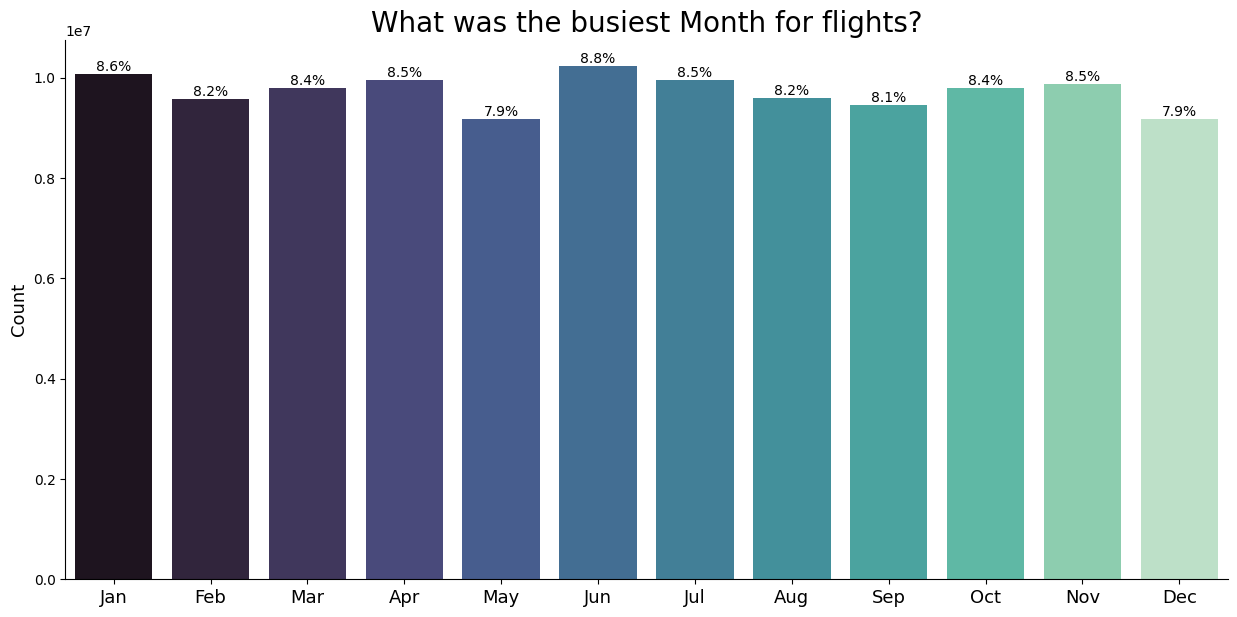

In [59]:
plt.figure(figsize=(15,7))
colors = [base_color if (x < Month_counts.max()) else alt for x in Month_counts ]
sns.barplot(x=month.index,y=Month_counts , palette = "mako");     
plt.xlabel('',size=13)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11],
           labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],size=13) 
plt.ylabel('Count',size=13)   
plt.title('What was the busiest Month for flights?',size=20) 
sns.despine()
for i in range (Month_counts.shape[0]):
    plt.text(i,                           
             Month_counts.values[i],       
             Month_text[i],                 
             ha='center',                  
             va='bottom')

In [60]:
day = flight.groupBy('DayofMonth').count().select('DayofMonth', f.col('Count')).toPandas()

In [61]:
day['DayofMonth'] = [ int(i) for i in day['DayofMonth']]
day_sorted = day.sort_values(by=['DayofMonth'], ascending=True)
day_sorted.head()

,DayofMonth,Count
22,1,3813790
30,2,3833628
4,3,3822338
25,4,3800314
10,5,3826832


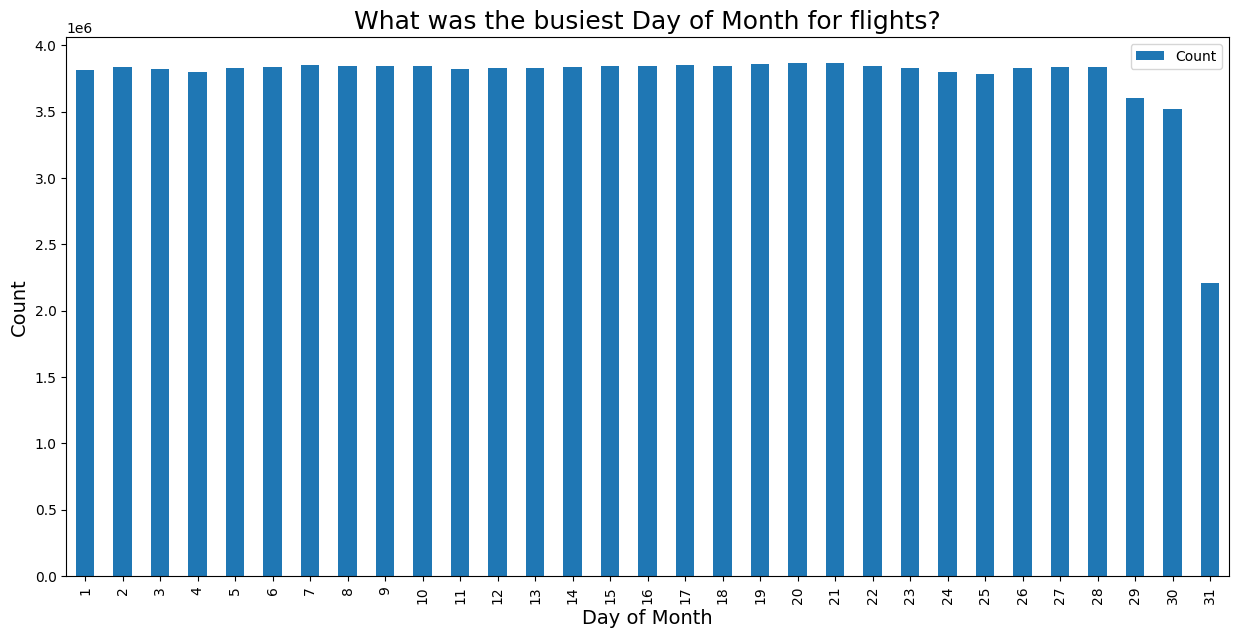

In [62]:
day_sorted.plot.bar(x='DayofMonth', y=['Count'], figsize=(15,7))
plt.xlabel("Day of Month", size=14)
plt.ylabel("Count", size=14)
plt.title("What was the busiest Day of Month for flights?", size=18)
plt.show()

In [63]:
week_days = flight.groupBy('DayOfWeek').count().select('DayOfWeek', f.col('Count')).toPandas()
week_days.set_index('DayOfWeek', inplace=True)

In [64]:
DayOfWeek_counts = week_days['Count']
DayOfWeek_text = ['{:0.1f}%'.format(v) for v in (DayOfWeek_counts/flight.count()*100)]

C:\Users\sharo\AppData\Local\Temp\ipykernel_3404\3430329896.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=week_days.index,y=DayOfWeek_counts, palette = "mako");


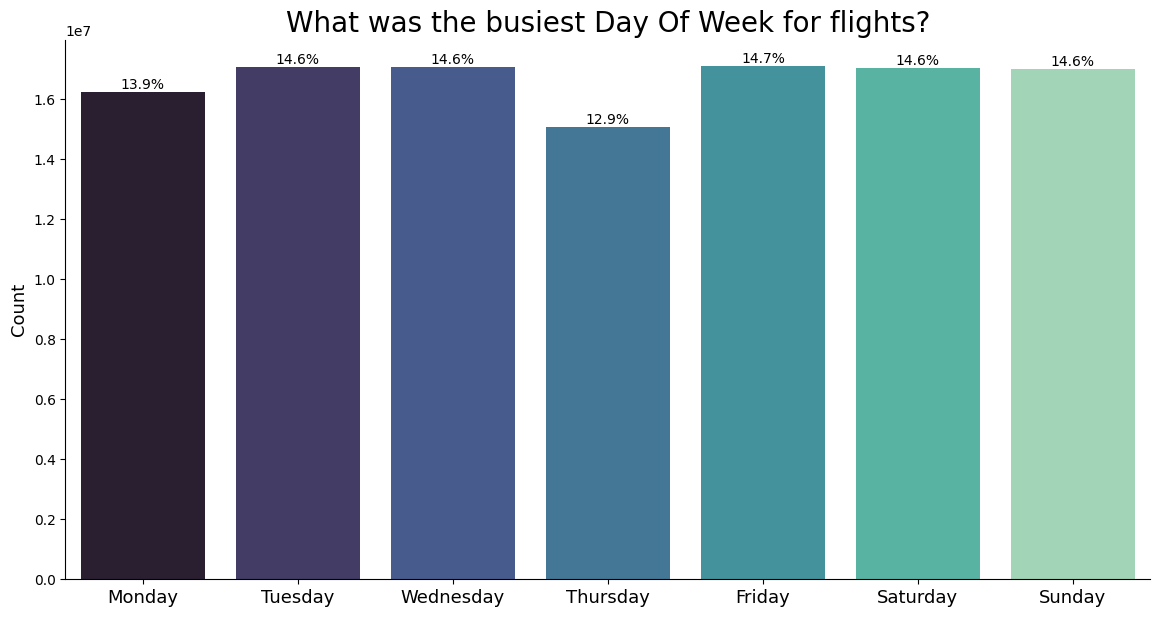

In [65]:
plt.figure(figsize=(14,7))
colors = [base_color if (x < DayOfWeek_counts.max()) else alt for x in DayOfWeek_counts ]
sns.barplot(x=week_days.index,y=DayOfWeek_counts, palette = "mako");     
plt.xlabel('',size=20)
plt.xticks(ticks=[0,1,2,3,4,5,6],
           labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],size=13) 
plt.ylabel('Count',size=13)   
plt.title('What was the busiest Day Of Week for flights?',size=20) 
sns.despine()
for i in range (DayOfWeek_counts.shape[0]):
    plt.text(i,                           
             DayOfWeek_counts.values[i],       
             DayOfWeek_text[i],                 
             ha='center',                  
             va='bottom')

In [66]:
unique_carrier = flight.groupBy('UniqueCarrier').count().select('UniqueCarrier', f.col('Count')).toPandas()
unique_carrier.set_index('UniqueCarrier', inplace=True)

In [67]:
carrier_counts = unique_carrier['Count']
carrier_text = ['{:0.1f}%'.format(v) for v in (carrier_counts/flight.count()*100)]

C:\Users\sharo\AppData\Local\Temp\ipykernel_3404\3754500679.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_carrier.index,y=carrier_counts,order=carrier_counts.index , palette = "mako");


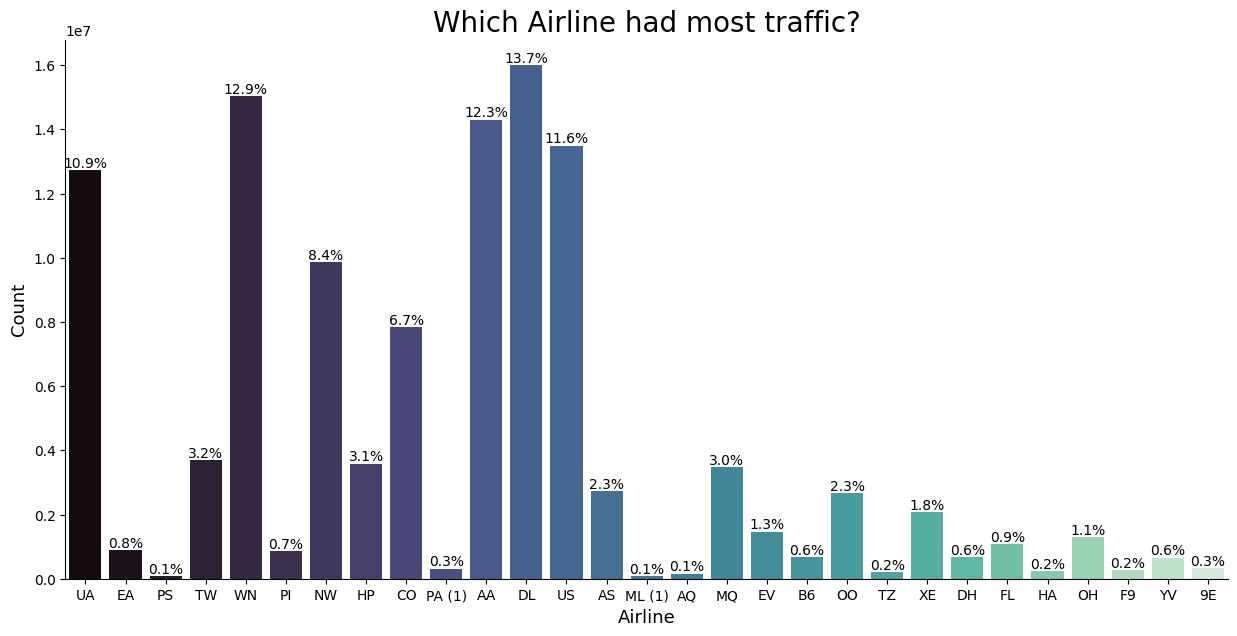

In [68]:
plt.figure(figsize=(15,7))
colors = [base_color if (x < carrier_counts.max()) else alt for x in carrier_counts ]
sns.barplot(x=unique_carrier.index,y=carrier_counts,order=carrier_counts.index , palette = "mako");     
plt.xlabel('Airline',size=13) 
plt.ylabel('Count',size=13)   
plt.title('Which Airline had most traffic?',size=20) 
sns.despine()
for i in range (carrier_counts.shape[0]):
    plt.text(i,                           
             carrier_counts.values[i],       
            carrier_text[i],                 
             ha='center',                  
             va='bottom')